<a href="https://colab.research.google.com/github/pushpendra-aibot/MyWork/blob/master/ResNet9_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import os
import torchvision
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision import models
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.autograd import Variable

In [2]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(), 
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)])
test_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

In [3]:
#importing the datasets
train_data = CIFAR10(root = './data', train = True, 
                     download = True, transform = train_tfms)
test_data = CIFAR10(root = './data', train = False,
                    download = True, transform = test_tfms)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [5]:
#printing out the train shape
img,label = train_data[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 6


tensor([[[-0.5293, -1.1109, -1.4598,  ...,  0.7307,  0.8276,  0.6531],
         [-0.7232, -1.4404, -2.0801,  ...,  0.1104,  0.1297,  0.1491],
         [-0.2967, -0.8201, -1.4792,  ...,  0.0328,  0.0910,  0.3236],
         ...,
         [ 1.1184,  1.2735,  1.4091,  ...,  0.1879, -0.6844, -1.4598],
         [ 1.4091,  1.3316,  1.1765,  ..., -0.4130, -1.3047, -1.7700],
         [ 1.4867,  1.2153,  1.0408,  ..., -0.1029, -0.6457, -0.4324]],

        [[-0.9826, -1.3562, -1.4742,  ...,  0.1581,  0.2564,  0.1188],
         [-1.4152, -1.8873, -2.2609,  ..., -0.6679, -0.6286, -0.5696],
         [-1.0022, -1.4349, -1.8873,  ..., -0.6679, -0.6089, -0.3532],
         ...,
         [ 0.4531,  0.6694,  0.7481,  ..., -0.3926, -1.0612, -1.9463],
         [ 0.6891,  0.5908,  0.4138,  ..., -1.1006, -1.8086, -2.3199],
         [ 0.8858,  0.5121,  0.3744,  ..., -0.7072, -1.1006, -0.8842]],

        [[-1.2069, -1.4020, -1.3825,  ..., -0.2704, -0.1143, -0.2313],
         [-1.8117, -2.0653, -2.2214,  ..., -1

In [6]:
#printing out the classes in the data
print(train_data.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
# PyTorch data loaders
batch_size = 400
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_loader = DataLoader(test_data, batch_size*2, num_workers=3, pin_memory=True)

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

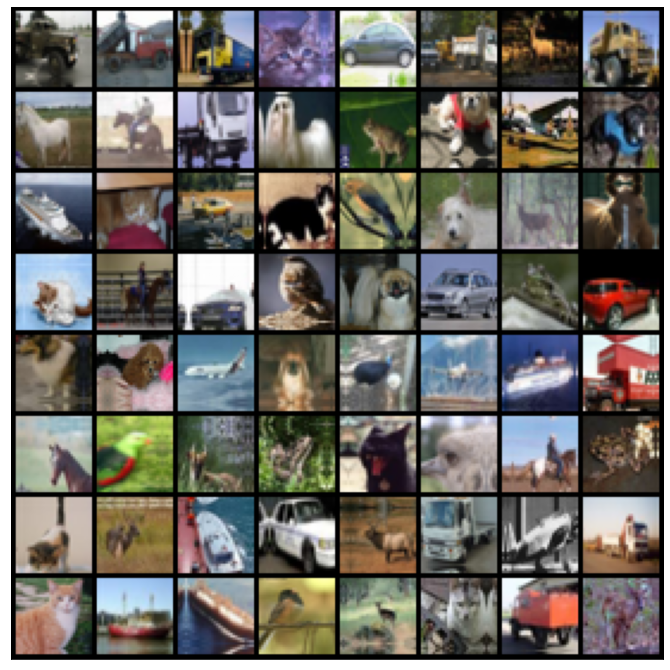

In [9]:
show_batch(train_loader)

In [10]:
#Using the GPU
def get_default_device():
    """Choose GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [13]:
#Residual Block 
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

In [14]:
#Building simple model using the Residual block
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_loader:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


In [32]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        #print(loss)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['test_loss'], result['test_acc']))

In [33]:
#Building the model

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [34]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [35]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [36]:
history = [evaluate(model, test_loader)]
history

[{'test_acc': 0.11115384101867676, 'test_loss': 2.3033812046051025}]

In [37]:
epochs = 10
max_lr = .01
grad_clip = 0.1
weight_decay = 1e-4
optim = torch.optim.Adam

In [39]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, test_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=optim)

Epoch [0], last_lr: 0.00278, train_loss: 1.5020, test_loss: 1.2353, test_acc: 0.5638
Epoch [1], last_lr: 0.00759, train_loss: 1.0369, test_loss: 1.3816, test_acc: 0.6028
Epoch [2], last_lr: 0.01000, train_loss: 0.9103, test_loss: 0.6841, test_acc: 0.7600
Epoch [3], last_lr: 0.00950, train_loss: 0.6769, test_loss: 0.8054, test_acc: 0.7510
Epoch [4], last_lr: 0.00812, train_loss: 0.5432, test_loss: 0.6465, test_acc: 0.7838
Epoch [5], last_lr: 0.00611, train_loss: 0.4574, test_loss: 0.4969, test_acc: 0.8302
Epoch [6], last_lr: 0.00389, train_loss: 0.3826, test_loss: 0.4565, test_acc: 0.8514
Epoch [7], last_lr: 0.00188, train_loss: 0.2976, test_loss: 0.3726, test_acc: 0.8773
Epoch [8], last_lr: 0.00050, train_loss: 0.2124, test_loss: 0.2747, test_acc: 0.9087
Epoch [9], last_lr: 0.00000, train_loss: 0.1627, test_loss: 0.2633, test_acc: 0.9152
CPU times: user 1min 45s, sys: 1min 25s, total: 3min 11s
Wall time: 5min 7s


In [40]:
# Plotting Accuracies
def plot_accuracies(history):
    accuracies = [x['test_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

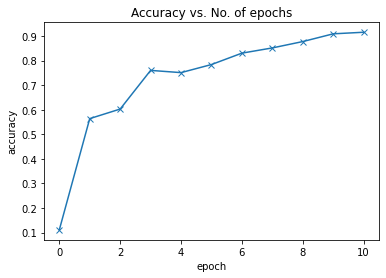

In [41]:
plot_accuracies(history)

In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['test_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Test'])
    plt.title('Loss vs. No. of epochs');

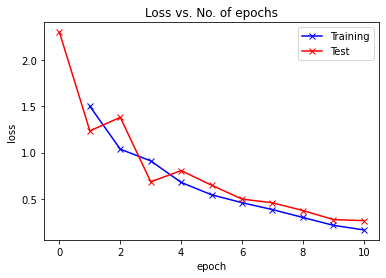

In [43]:
plot_losses(history)

In [48]:
import numpy as np
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

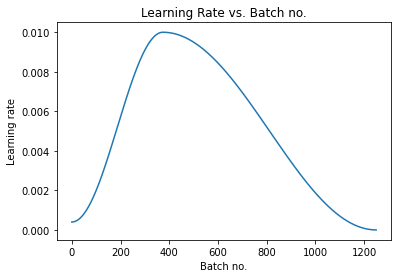

In [49]:
plot_lrs(history)

In [50]:
#Saving the model 
torch.save(model.state_dict(), 'ResNet9_Ques1.pth')

## ART Toolbox

In [51]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 890kB 8.7MB/s 
     |████████████████████████████████| 235kB 18.6MB/s 
     |████████████████████████████████| 21.0MB 169kB/s 
     |████████████████████████████████| 747kB 47.7MB/s 


In [52]:
from art.attacks.evasion import FastGradientMethod 

In [ ]:
def fgsm_attack()